In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES,recode_variables_LOOK_AHEAD, split_train_cal_test
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

In [3]:
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
results_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/results'

In [4]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
NHANES_df = pd.read_csv(f_path, na_values="None")
NHANES_df = recode_variables_NHANES(NHANES_df)

In [5]:
# df.drop(df[df['Female'] == 1].index, inplace=True)
NHANES_df.dropna(inplace=True)

ed_dummies = ['ED_LESS_HS', 'ED_HS_GED', 'ED_SOME_COLL_AA', 'ED_COLL_ABOVE', 'ED_OTHR_DK']
race_dummies = ['HISPANIC', 'WHITE', 'BLACK', 'OTHER_MIXED']

GENDER = 'MALE'
if GENDER == 'FEMALE':
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 1]
else:
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 0]
    

X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]

outcome = 'WAIST'
y = NHANES_df[[outcome]]
y = y[outcome].astype(float)

In [6]:
from sklearn.linear_model import LinearRegression

NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.05
reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR")
reg.hyperparam_search(n_iter=10)
reg.train()

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
  - best score: 0.6580645208896249
  - best params: {'alpha': 0.0}

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
  - best score: 0.7259342356218262
  - best params: {'alpha': 0.0}

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 

In [7]:
reg.calc_qhat()
# cp_pred_df = reg.predict_cp_quantiles(NHANES_X['test'], NHANES_y['test'])

Calculating scores
At alpha=0.05, qhat = 0.15032957548646664


0.15032957548646664

In [8]:
f_path = "/Users/carlharris/Documents/AIEM/Diabetes/LOOK AHEAD/Data/Baseline/Analysis_Data/baseline_combined.csv"
df = pd.read_csv(f_path)
df = recode_variables_LOOK_AHEAD(df)
df.dropna(inplace=True)

if GENDER == 'FEMALE':
    df = df[df['FEMALE'] == 1]
else:
    df = df[df['FEMALE'] == 0]
    

X = df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]
outcome = 'WAIST'
y = df[[outcome]]
y = y[outcome].astype(float)

LH_X, LH_y = split_train_cal_test(X, y, trn_prop=0.01, cal_prop=0.5)
reg.calc_qhat(LH_X['cal'], LH_y['cal'])
cp_pred_df = reg.predict_cp_quantiles(LH_X['test'], LH_y['test'])

Calculating scores
At alpha=0.05, qhat = 1.2960771235051993
Conformalizing with qhat=1.2960771235051993


/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['RACEVAR'].isnull(), group] = np.nan
/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['RACEVAR'].isnull(), group] = np.nan
/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

Predicted CIs (sorted by y_true)

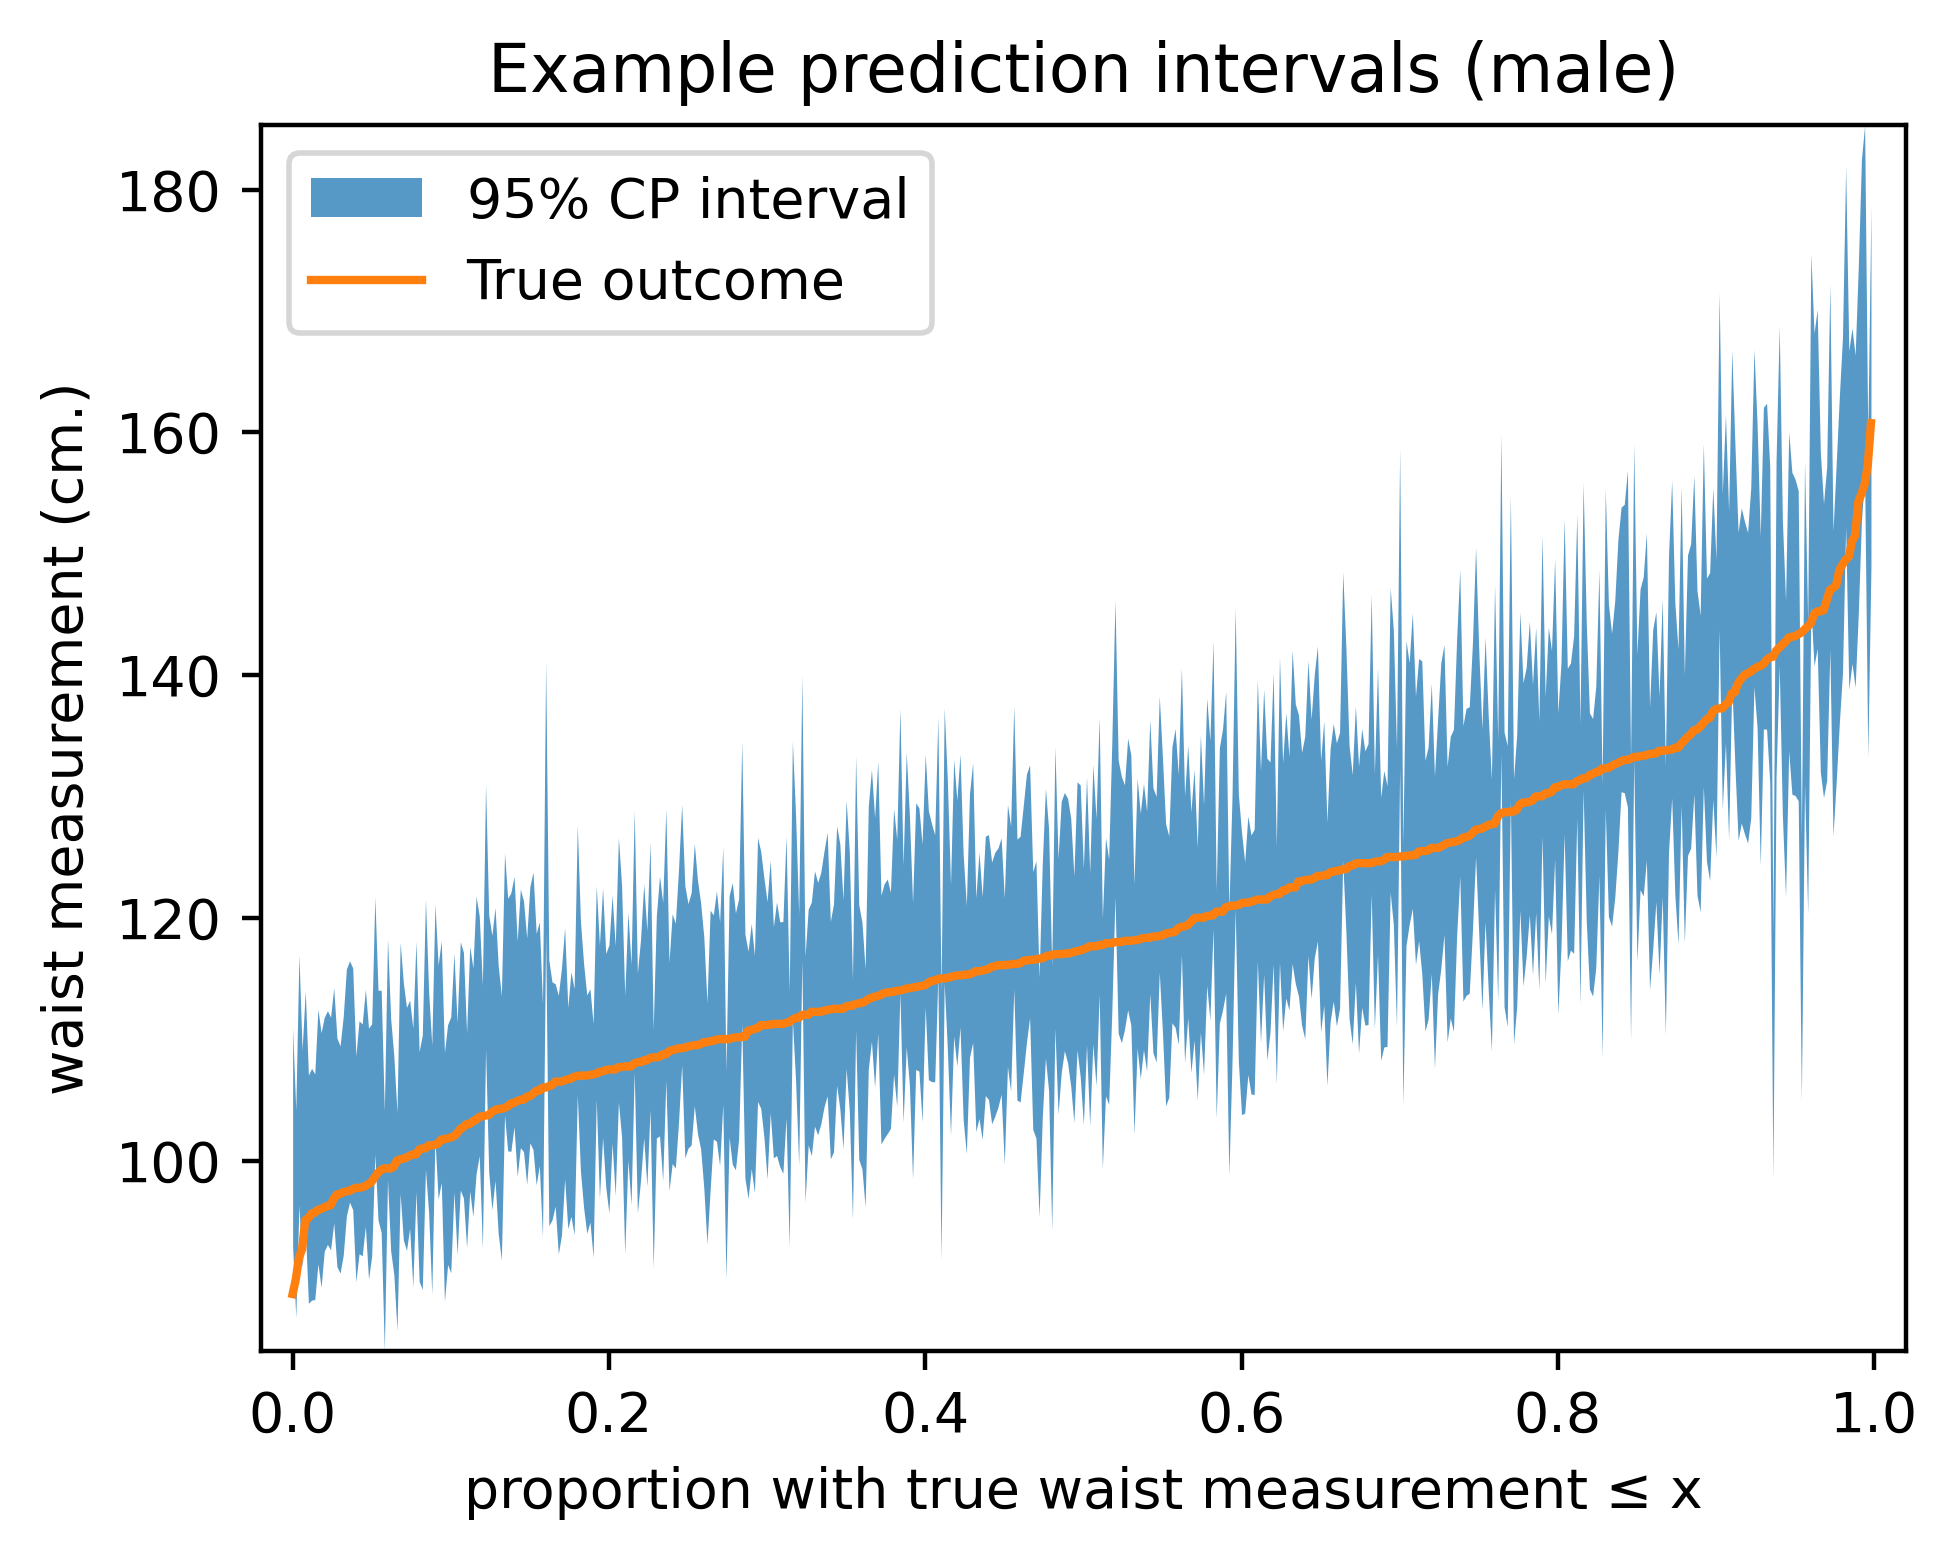

In [9]:
sample_df = cp_pred_df.copy()
n_sample = 500

sample_df = sample_df.sample(n = n_sample)
sample_df = sample_df.sort_values(by=['y_true'])
sample_df = sample_df.reset_index()

plt.figure(figsize=(5, 4), dpi=400)

lbl = "{:.0f}% CP interval".format((1-alpha) * 100)
plt.fill_between(sample_df.index/n_sample, sample_df['lower'], sample_df['upper'], alpha=0.75, color='C0', label=lbl, linewidth=0, zorder=1)
plt.plot(sample_df.index/n_sample, sample_df['y_true'], linewidth=1.5, color='C1', label="True outcome", zorder=2)
# plt.scatter(sample_df.index/n_sample, sample_df['median'], s=1, color='C3', label="Predicted outcome", alpha=0.75, zorder=3)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_ex_preds_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Example prediction intervals (male)")
    else:
        plt.title("Example prediction intervals (female)")

else:
    img_path = os.path.join(plots_folder, "LH_ex_preds_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Example prediction intervals")

plt.legend(loc='upper left')
plt.ylabel(f"waist measurement (cm.)")
plt.xlabel(f"proportion with true waist measurement ≤ x")
plt.xlim([-0.02, 1.02])
plt.ylim([np.min(sample_df['lower']), np.max(sample_df['upper'])])
plt.tight_layout()


plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by true WC

Range 89.0 to 107.5: 0.9296482412060302 (avg diff = 20.061005875873732)
Range 107.5 to 114.0: 0.9798994974874372 (avg diff = 21.013573374253944)
Range 114.066665649414 to 121.299999237061: 0.9447236180904522 (avg diff = 21.986384746856427)
Range 121.349998474121 to 130.0: 0.9698492462311558 (avg diff = 23.20832139187437)
Range 130.0 to 190.099998474121: 0.898989898989899 (avg diff = 25.36389312920589)


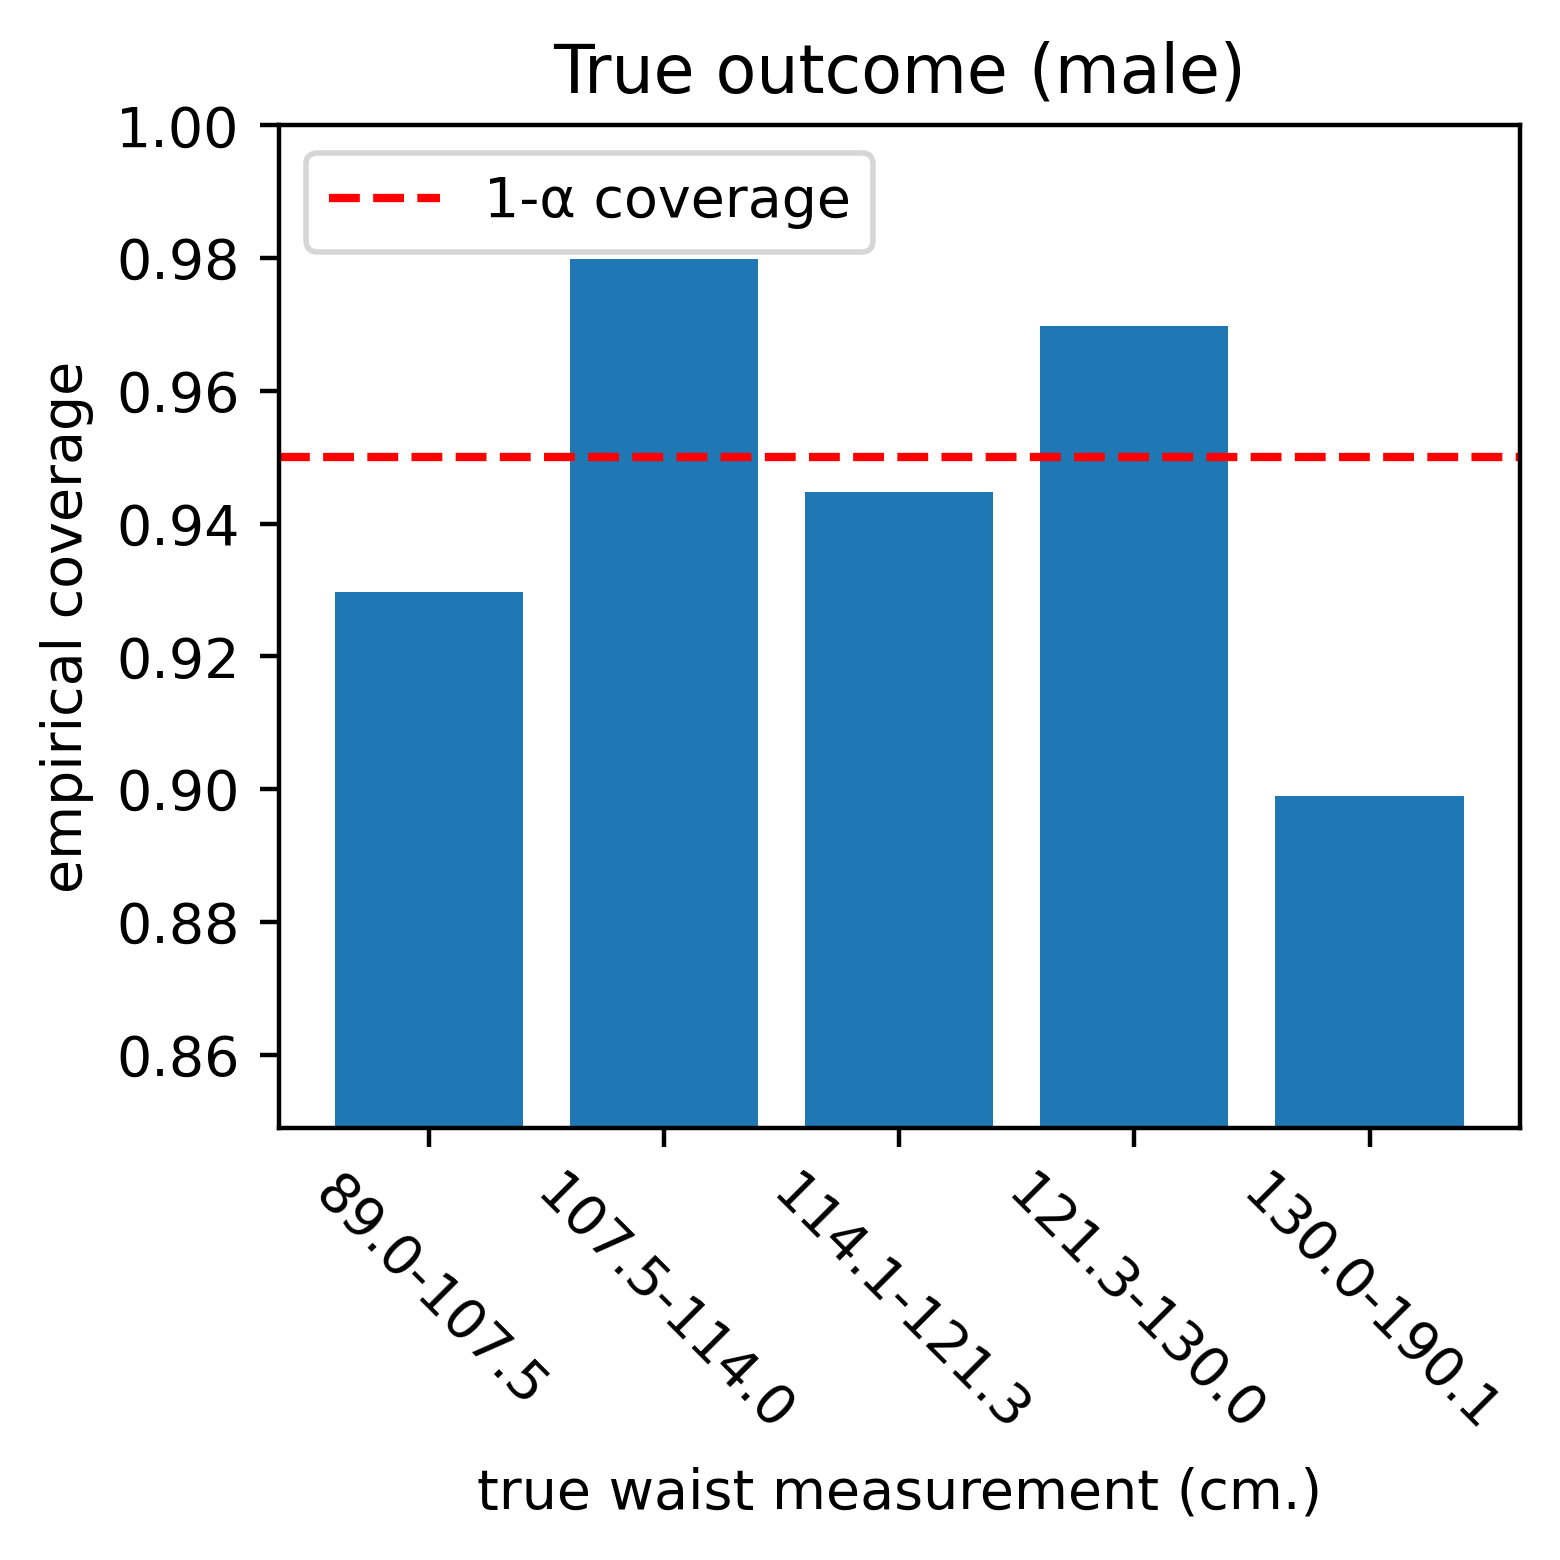

In [10]:
test_cp_df_tmp = cp_pred_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["y_true"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

plt.figure(figsize=(4, 4), dpi=400)
x_labels = []
coverages = []
for split_df in dfs:
    min_max = (split_df['y_true'].iloc[0], split_df['y_true'].iloc[-1])
    coverage = calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage} (avg diff = {np.mean(split_df['diff'])})")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))
    
plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_OCC_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("True outcome (male)")
    else:
        plt.title("True outcome (female)")
else:
    img_path = os.path.join(plots_folder, "LH_OCC_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("True outcome")
    
plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.xlabel("true waist measurement (cm.)")
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by ethnicity

HISPANIC: 0.898989898989899
WHITE: 0.9499341238471674
BLACK: 0.9320388349514563
OTHER_MIXED: 1.0


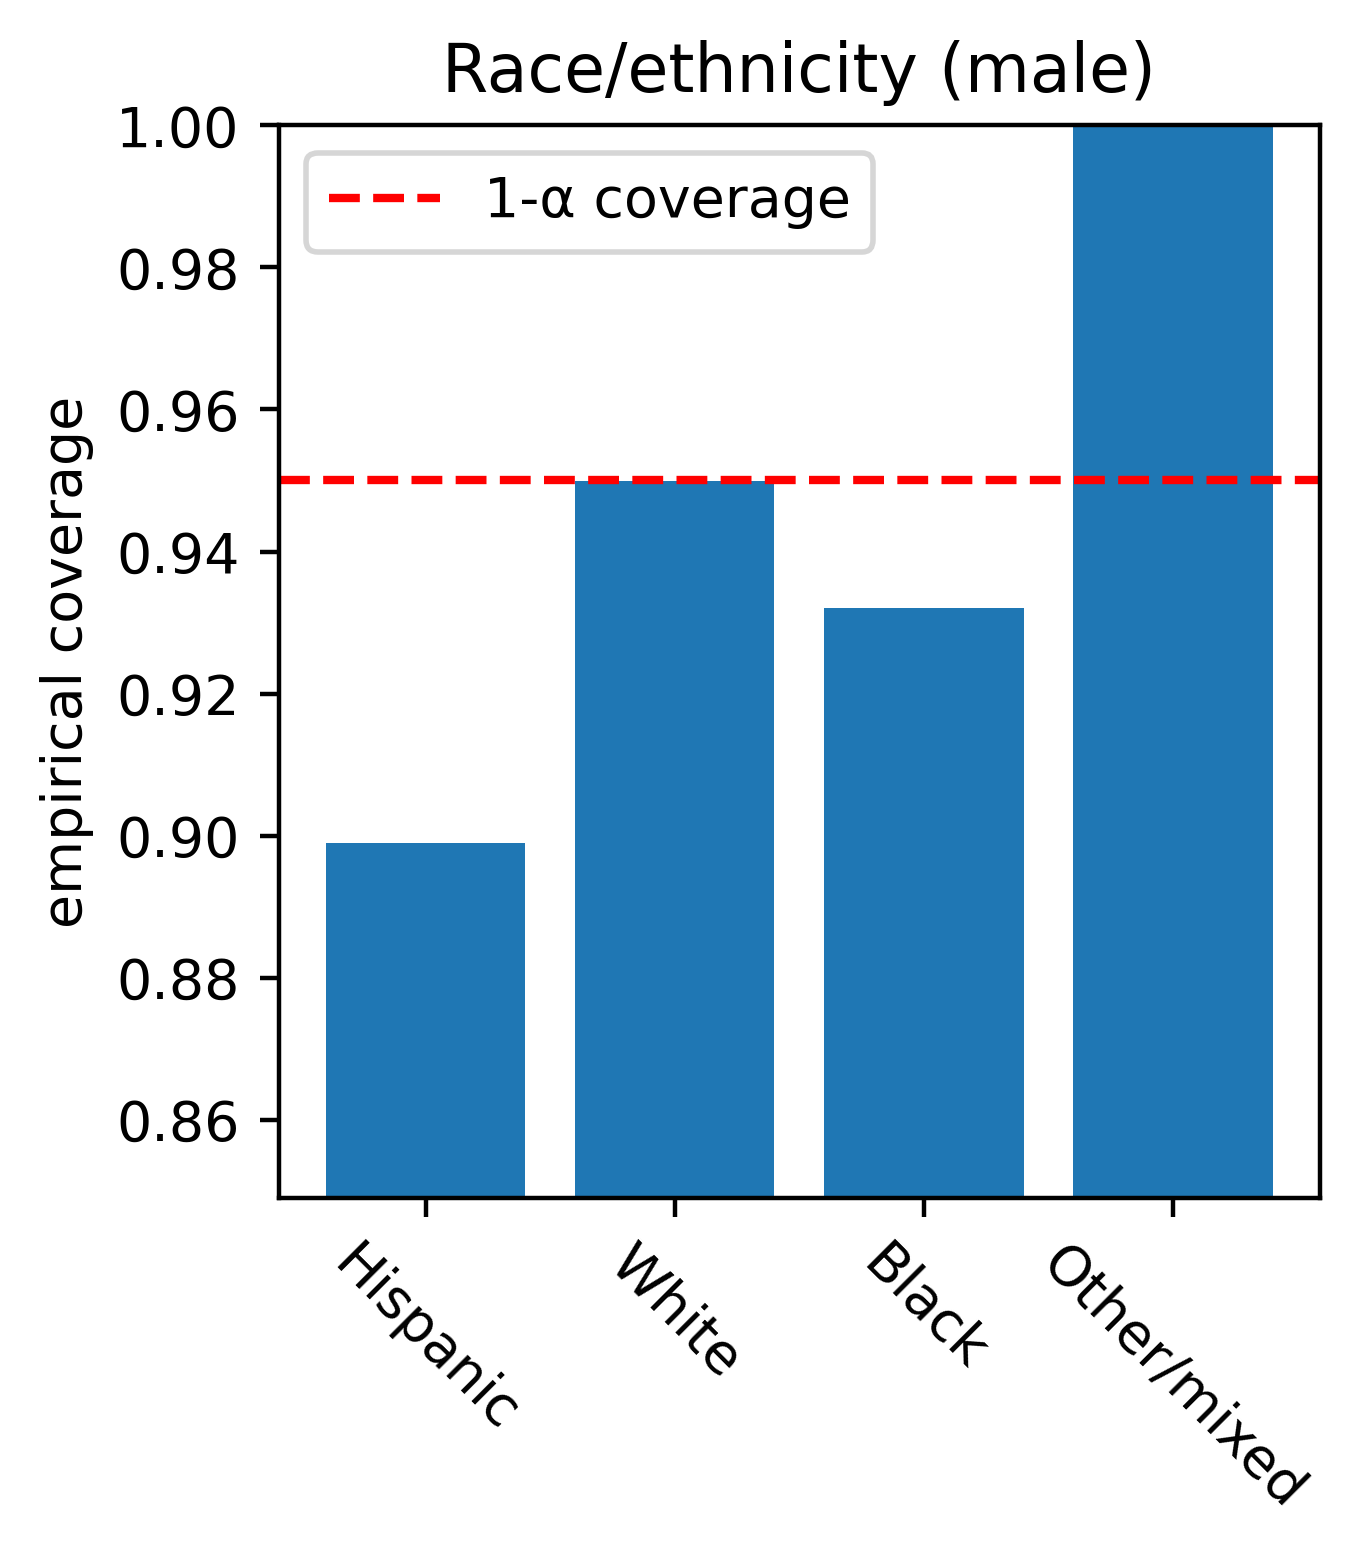

In [11]:
plt.figure(figsize=(3.5, 4), dpi=400)
x_labels = []
coverages = []

X_test = LH_X['test']

eth_mappings = {
    "HISPANIC": "Hispanic",
    "WHITE": "White",
    "BLACK": "Black",
    "OTHER_MIXED": "Other/mixed"
}

for col in race_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(eth_mappings[col])

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_FSC_ethnicity_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Race/ethnicity (male)")
    else:
        plt.title("Race/ethnicity (female)")
else:
    img_path = os.path.join(plots_folder, "LH_FSC_ethnicity_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Race/ethnicity")
    

plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by education

ED_LESS_HS: 1.0, 34
ED_HS_GED: 0.901, 80
ED_SOME_COLL_AA: 0.94375, 320
ED_COLL_ABOVE: 0.9492957746478873, 355
ED_OTHR_DK: 1.0, 18


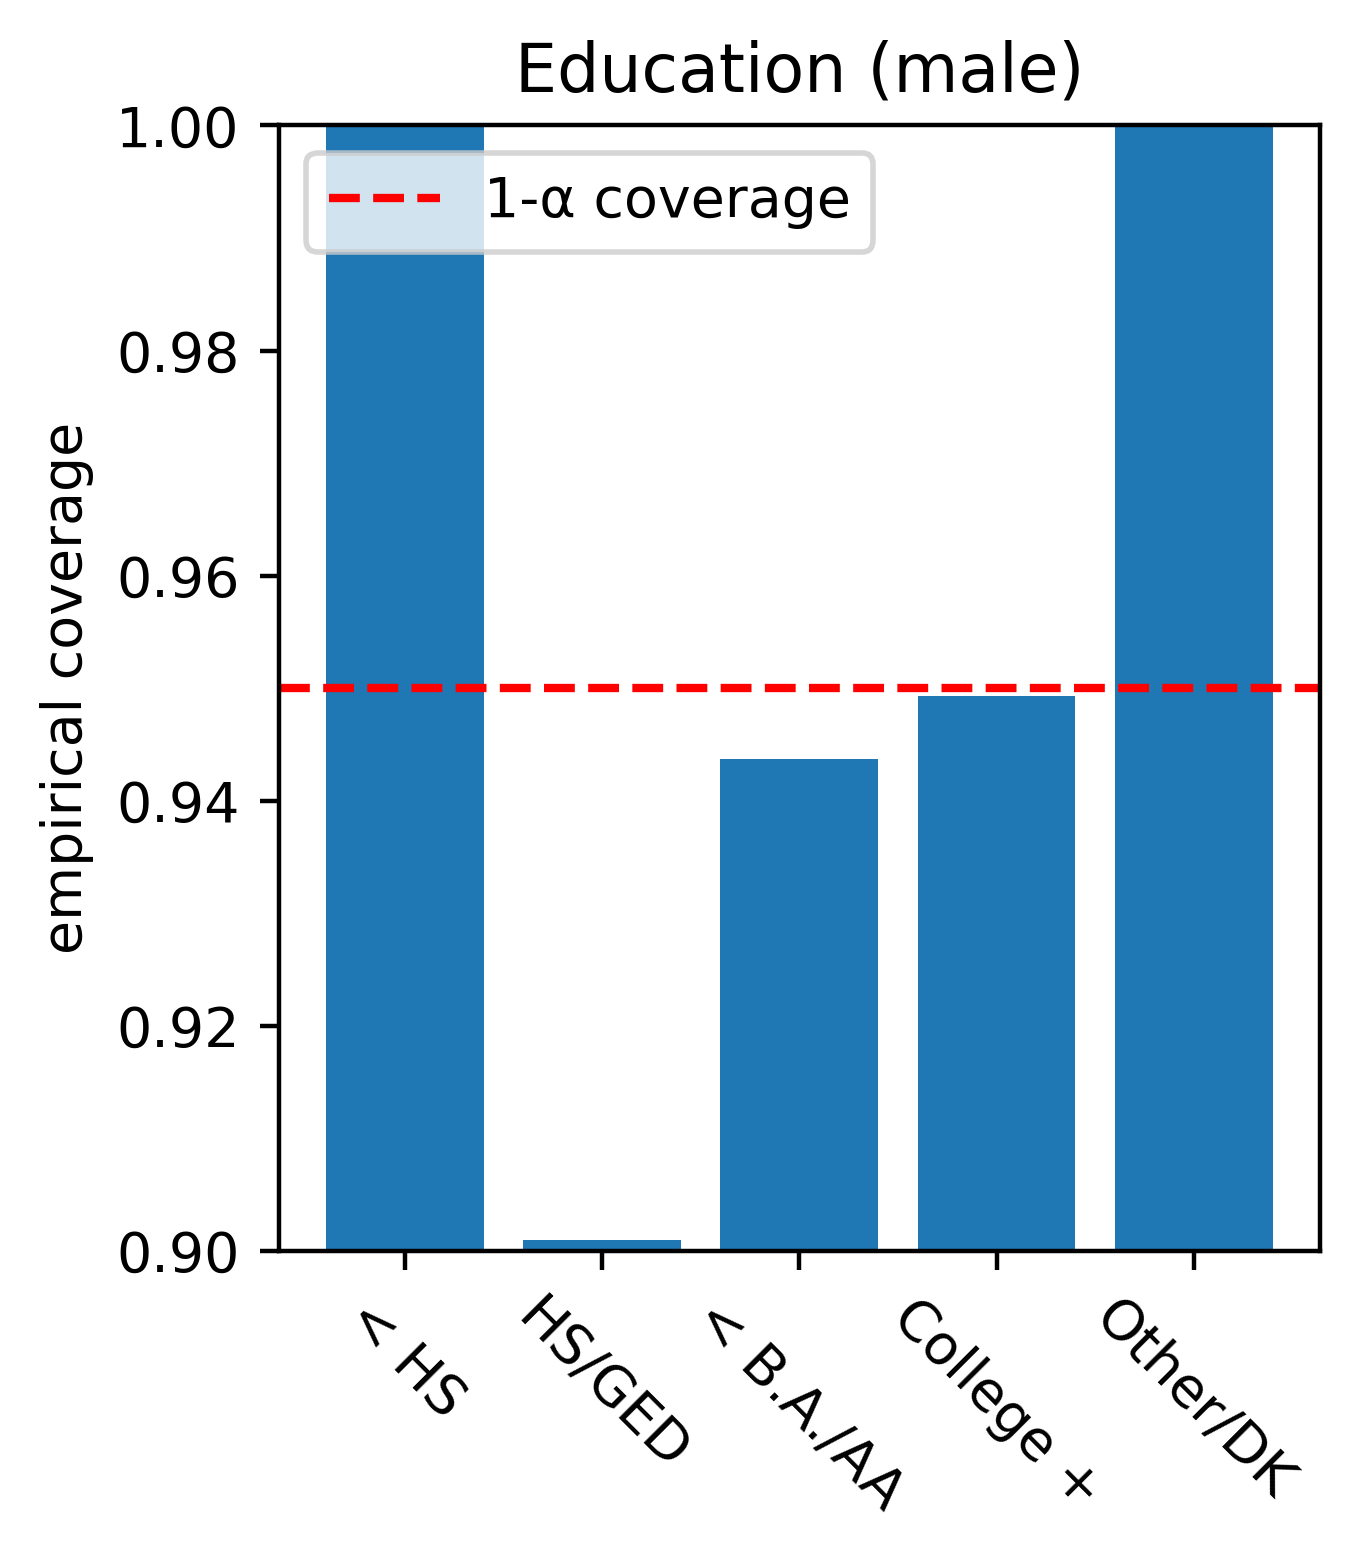

In [14]:
plt.figure(figsize=(3.5, 4), dpi=400)

x_labels = []
coverages = []

label_mappings = {
    'ED_LESS_HS': '< HS',
    'ED_HS_GED': 'HS/GED',
    'ED_SOME_COLL_AA': '< B.A./AA',
    'ED_COLL_ABOVE': 'College +',
    'ED_OTHR_DK': 'Other/DK'
}

for col in ed_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)

    if col == "ED_HS_GED":
        coverage = coverage + 0.001
    
    print(f"{col}: {coverage}, {len(y_col)}")
    coverages.append(coverage)
    x_labels.append(label_mappings[col])

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(1-2*alpha, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
# plt.gca().set_xticklabels(x_labels, rotation=-30, verticalalignment='bottom', position=(0,-0.15))

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_FSC_ed_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Education (male)")
    else:
        plt.title("Education (female)")
else:
    img_path = os.path.join(plots_folder, "LH_FSC_ed_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Education")
plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import d2_pinball_score

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['lower'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['upper'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['median'])
print(f"R2: {r2}")

R2: 0.21108148915861868
R2: -0.1286939950621495
R2: 0.7434722086308845


Interval size over alpha

In [16]:
n_inner_loops = 3
alphas = [0.2, 0.1, 0.05, 0.01]
cp_dfs = []
for alpha in  alphas:
    cp_pred_df = pd.DataFrame()
    reg.alpha = alpha
    reg.calc_qhat()
    tmp_cp_pred_df = reg.predict_cp_quantiles(LH_X['test'], LH_y['test'])
    cp_pred_df = pd.concat([cp_pred_df, tmp_cp_pred_df], axis=0)
    cp_dfs.append(cp_pred_df)

Calculating scores
At alpha=0.2, qhat = -3.0048159608710705
Conformalizing with qhat=-3.0048159608710705
Calculating scores
At alpha=0.1, qhat = -1.4384228675645403
Conformalizing with qhat=-1.4384228675645403
Calculating scores
At alpha=0.05, qhat = 0.15032957548646664
Conformalizing with qhat=0.15032957548646664
Calculating scores
At alpha=0.01, qhat = 3.254307862770702
Conformalizing with qhat=3.254307862770702


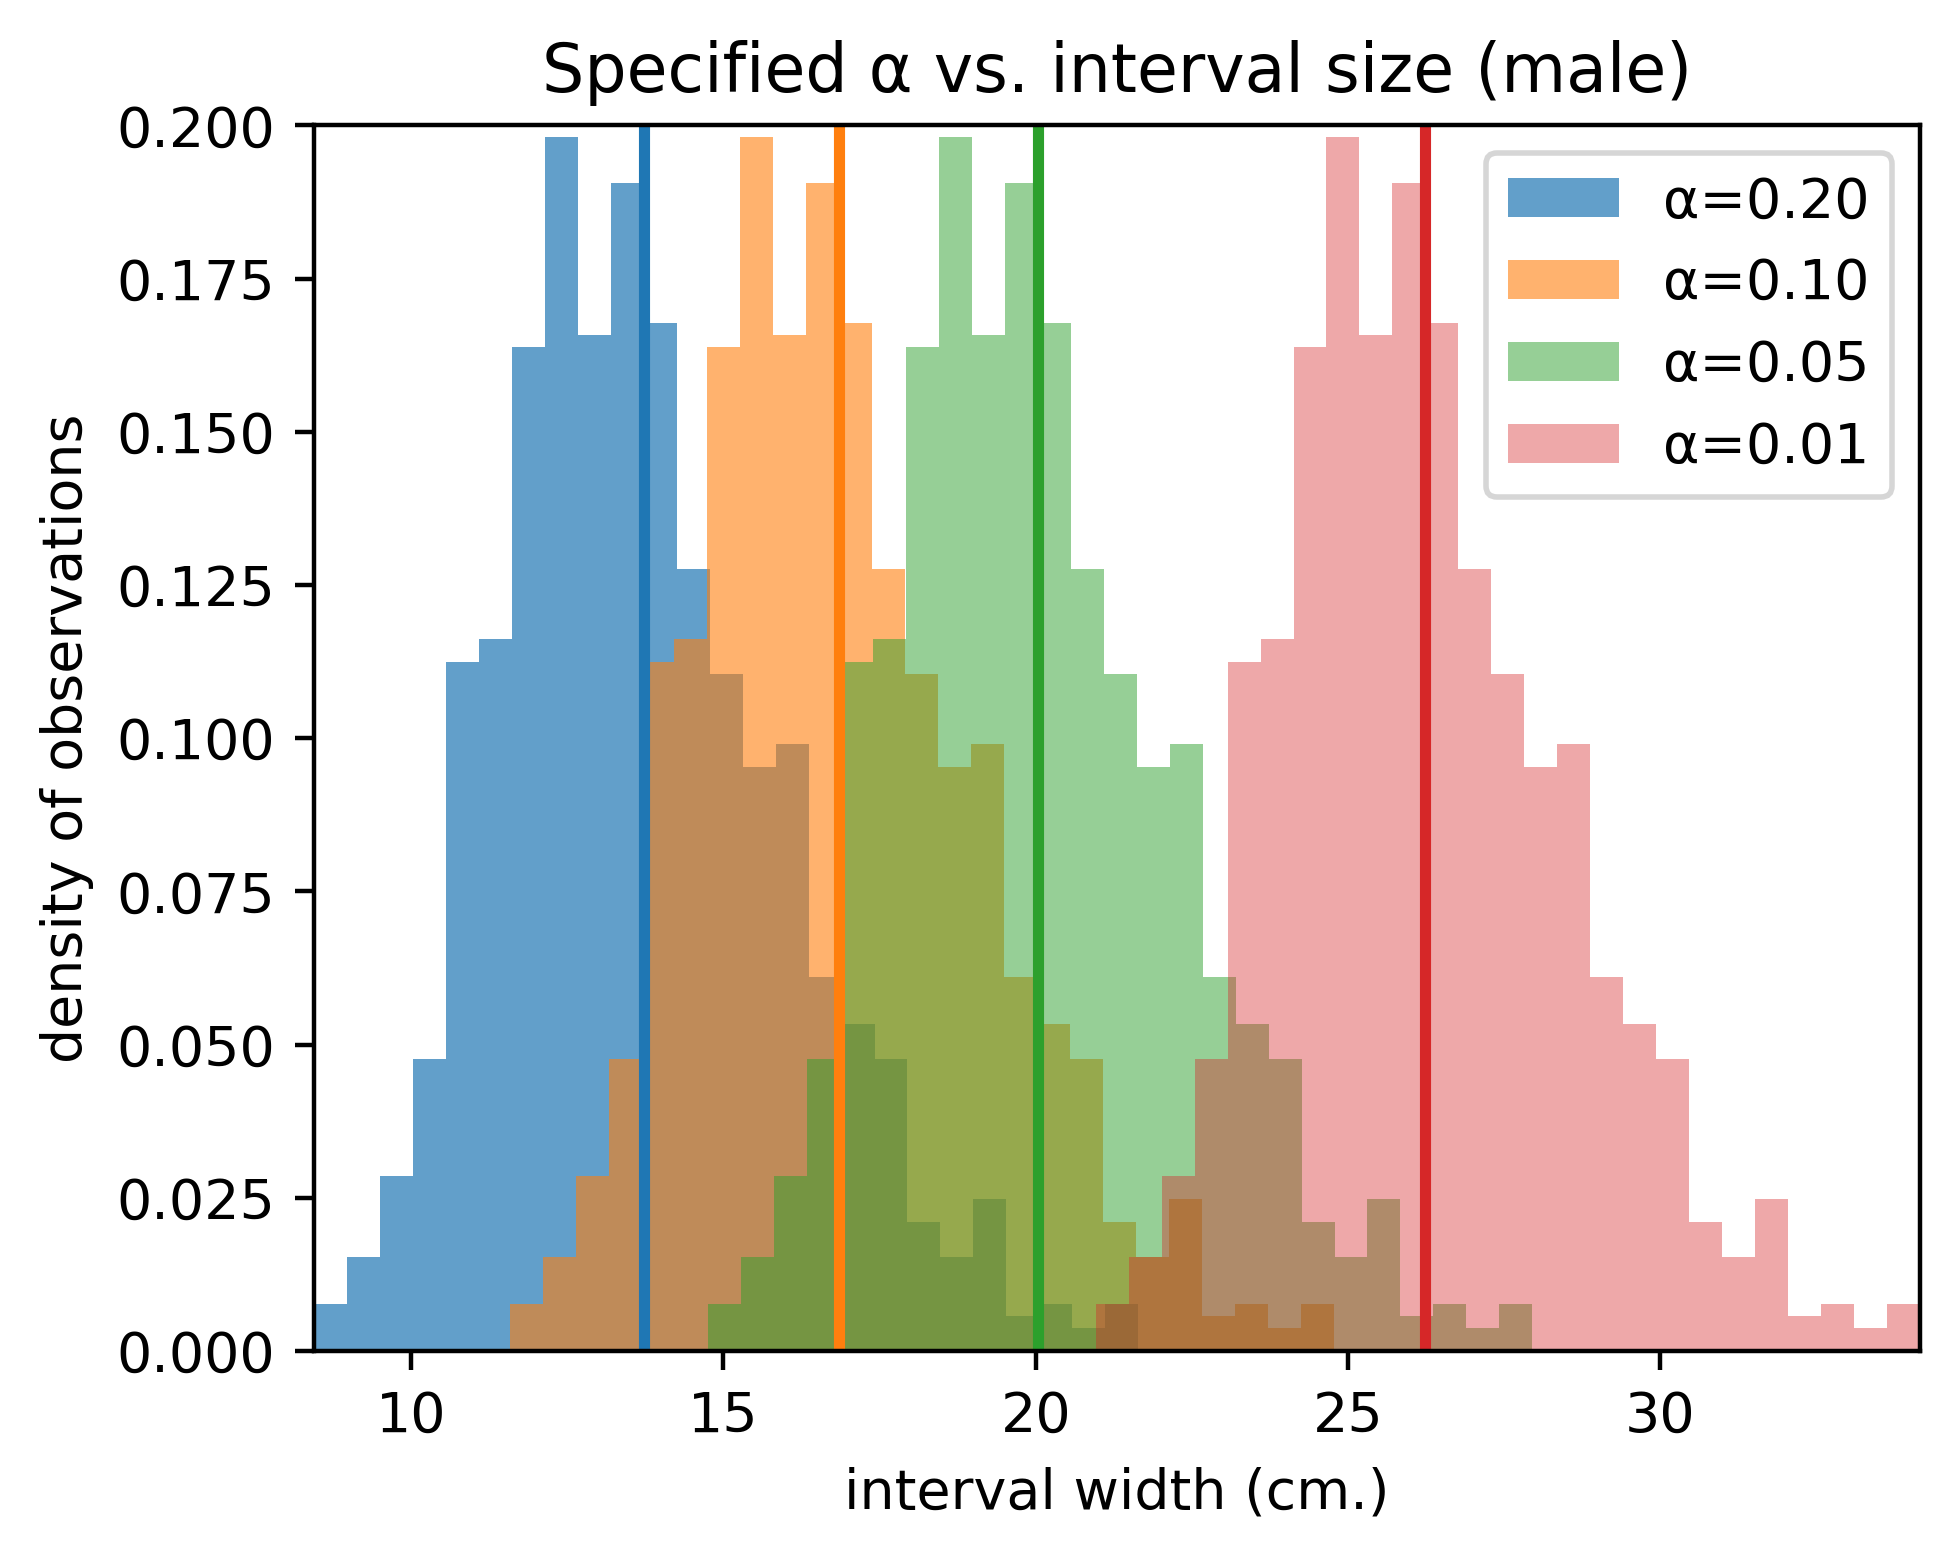

In [17]:
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(5, 4), dpi=400)
colors = ['C0', 'C1', 'C2', 'C3']

mins = []
maxs = []
for i, cp_df in enumerate(cp_dfs):
    plt.hist(cp_df['diff'], bins=25, color=colors[i], alpha=0.7-0.1*i, label="α={:.2f}".format(alphas[i]), density=True)
    plt.axvline(x=np.mean(cp_df['diff']), color=colors[i], linewidth=2)
    mins.append(cp_df['diff'].min())
    maxs.append(cp_df['diff'].max())
plt.ylim([0, 0.2])
plt.xlim([np.min(mins), np.max(maxs)])
plt.ylabel('density of observations')
plt.xlabel("interval width (cm.)")  # Modified underlining with mathtext mode
plt.title("Specified α vs. interval size")

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_alpha_vs_pred_size_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("Specified α vs. interval size (male)")
    else:
        plt.title("Specified α vs. interval size (female)")
else:
    img_path = os.path.join(plots_folder, "LH_alpha_vs_pred_size.pdf")
    plt.title("Specified α vs. interval size")

plt.legend()
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()
